<a href="https://colab.research.google.com/github/Voztok94/Extra-Credit/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install face_recognition
import face_recognition
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=350cd831b56dff77b435bd35d140ad9713b45eb0443fc1f3bbde0bd7991ea40d
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [35]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Path to the known and unknown faces folders
known_faces_dir = "/content/drive/MyDrive/Faces/known/known"
aligned_faces_dir = "/content/drive/MyDrive/Faces/unknown/unknown"

Failed to load image at: /content/drive/MyDrive/Faces/known/known/encodings.npy
Failed to load image at: /content/drive/MyDrive/Faces/known/known/names.npy


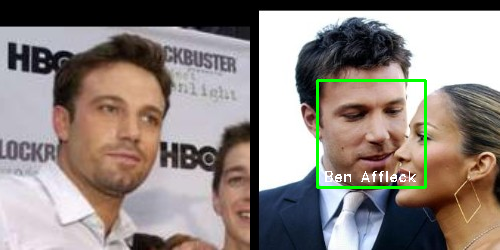

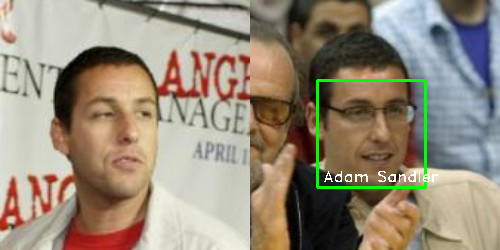

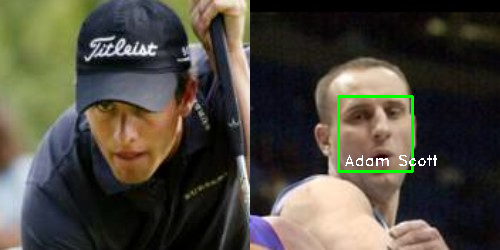

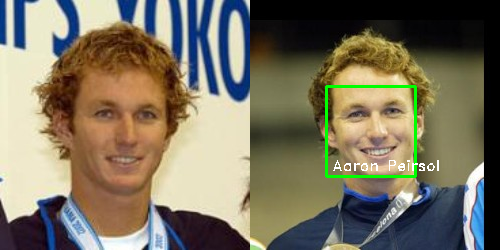


the following are unidentified images:
Adam_Scott_0002.jpg

The following people are missing:
Mike Pence
Donald Trump


In [37]:
# Function to resize and load the image
def read_image(path):
    img = cv2.imread(path)
    if img is None:  # Check if image loading was successful
        print(f"Failed to load image at: {path}")  # Print the problematic path
        return None
    (h, w) = img.shape[:2]
    width = 250
    ratio = width / float(w)
    height = int(h * ratio)
    return cv2.resize(img, (width, height))

# Initialize known encodings and names
known_encodings = []
known_names = []
known_dir = '/content/drive/MyDrive/Faces/known/known'
unknown_faces_dir = '/content/drive/MyDrive/Faces/unknown/unknown'
used_known_names = set()

for file in os.listdir(known_dir):
    if os.path.isdir(os.path.join(known_dir, file)):
        continue
    img = read_image(os.path.join(known_dir, file))
    if img is None:
        continue  # Skip to the next file if it fails to load
    img_enc = face_recognition.face_encodings(img)
    if len(img_enc) > 0:
        known_encodings.append(img_enc[0])
        known_names.append(file.split('.')[0])

# Variables to store unmatched face names and unused file names
unmatched_known_faces = []
unmatched_unknown_files = []

# Process unknown faces
for unknown_file in os.listdir(unknown_faces_dir):
    if os.path.isdir(os.path.join(unknown_faces_dir, unknown_file)):
        continue
    unknown_img = read_image(os.path.join(unknown_faces_dir, unknown_file))
    if unknown_img is None:  # Skip if image loading failed
        continue

    # Get face encodings for the unknown image
    unknown_encodings = face_recognition.face_encodings(unknown_img)
    if len(unknown_encodings) == 0:  # No faces found in the image
        unmatched_unknown_files.append(unknown_file)
        continue

    # Process each face in the unknown image
    match_found = False
    for unknown_encoding in unknown_encodings:
        matches = face_recognition.compare_faces(known_encodings, unknown_encoding)
        face_distances = face_recognition.face_distance(known_encodings, unknown_encoding)
        best_match_index = np.argmin(face_distances)

        if matches[best_match_index]:
            match_found = True
            name = known_names[best_match_index]
            used_known_names.add(name)

            # Iterate over face locations and draw rectangle and label for each face
            for (top, right, bottom, left) in face_recognition.face_locations(unknown_img):
                cv2.rectangle(unknown_img, (left, top), (right, bottom), (0, 255, 0), 2)
                cv2.putText(unknown_img, name, (left + 6, bottom - 6), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)

            known_img_path = os.path.join(known_faces_dir, name + ".jpg")
            known_img = read_image(known_img_path)
            combined_img = np.hstack((known_img, unknown_img))
            cv2_imshow(combined_img)
            break

    if not match_found:
        unmatched_unknown_files.append(unknown_file)  # Add to unmatched list

# After matching, display the unmatched faces and unused files
print("\nthe following are unidentified images:")
print("\n".join(set(unmatched_unknown_files)))

unused_known_names = set(known_names) - used_known_names
print("\nThe following people are missing:")
print("\n".join(unused_known_names))